# Gaussian Process Regression

This notebook aims to implement most of the functions and algorithms of C.E.Rasmussen & C.K.I Williams: $\textit{Gaussian Processes for Machine Learning}$ chapter 2 Regression (pp 7) in Numpy.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv

A set of test inputs $\pmb{X_*}$ is created.

In [2]:
# Test inputs
num_test_samples = 100
X_test = np.linspace(-2 * np.pi, 2 * np.pi, num_test_samples).reshape(num_test_samples,1)

## Gaussian Process

A Gaussian Process $f(\pmb{x}) \sim \mathcal{GP}\left(m \left(\pmb{x}\right),k\left(\pmb{x}, \pmb{x}'\right)\right)$ is completely defined by its mean function 

$m(\pmb{x}) = \mathbb{E} \begin{bmatrix} f(\pmb{x}) \end{bmatrix}$

and by its covariance function (kernel)

$k\left(\pmb{x}, \pmb{x}' \right) = \mathbb{E}\begin{bmatrix}\left(f \left(\pmb{x}\right) - m \left(\pmb{x} \right)\right)\left(f \left(\pmb{x}'\right) - m \left(\pmb{x}' \right)\right)\end{bmatrix}$. 

Therefore, a Gaussian Process is a generalization of a Gaussian distribution over vectors to a distribution over functions. For the following calculations, the squared-expoential covariance function is applied. 

#### Covariance function (kernel)

There exists a variety of covariance functions. Here the squared-exponential covariance function given by

$k\left(x_p, x_q \right) = \sigma_f^2 \mathrm{exp}\left(- \frac{1}{2l^2} \left(x_p - x_q\right)^2\right)$

with $l$ being the length scale and $\sigma_f^2$ the signal variance is applied. Both parameters are hyperparameters.

In [3]:
# Covariance function (kernel)

def covariance_function(X_p, X_q, sigma_f = 1.0, l = 1.0):
    """"
    Squared-exponential covariance function calculating the covariance matrix
    
    X_p is (m x n) matrix
    """

    squared_dist = np.sum(X_p**2, 1).reshape(-1, 1) - 2 * X_p @ X_q.T + np.sum(X_q**2, 1)
    
    return sigma_f**2 * np.exp(-1/(2 * l**2) * squared_dist) 

Applying the mean function $m(\pmb{x})$ and the covariance function $k\left(\pmb{x}, \pmb{x}'\right)$, a random function vector $\pmb{\mathrm{f}}$ is generated by a Gaussian Process $\mathcal{GP}\left(m \left(\pmb{x}\right),k\left(\pmb{x}, \pmb{x}'\right)\right)$ through

1. computing the components $\mu_i$ of the mean vector $\pmb{\mu}$ for each input $\pmb{x}_i$ using the mean function $m(\pmb{x}_i)$,
2. computing the components $K_{ij}$ of the covariance matrix $\pmb{K}$ using the covariance function $k\left(\pmb{x}, \pmb{x}'\right)$, and
3. finally drawing  a function vector $\pmb{\mathrm{f}} = \begin{bmatrix}f(\pmb{x}_1), \dots, f(\pmb{x}_n)\end{bmatrix}^T$ from the Gaussian distribution $\mathcal{N}(\pmb{\mathrm{f}} \rvert \pmb{\mu}, \pmb{K})$.

## Prior distribution

This procedure is now used for the prior distribution $\pmb{\mathrm{f}}_* \sim \mathcal{N}(\pmb{0}, \pmb{K}(\pmb{X}_*, \pmb{X}_*))$. The covariance function $k \left(\pmb{x}, \pmb{x}'\right)$ is applied to calculate the prior covariance matrix $\pmb{K}(\pmb{X}_*, \pmb{X}_*)$. For the prior mean $\pmb{\mu} = \pmb{0}$ is assumed. Having determined the prior distribution $\mathcal{N}\left(\pmb{\mathrm{f}}_* \rvert \pmb{0}, \pmb{K}\left(\pmb{X}_*, \pmb{X}_*\right)\right)$, random function vectors $\pmb{\mathrm{f}}_*$ can be drawn from this distribution

In [4]:
# Calculating prior covariance matrix and prior mean
prior_cov = covariance_function(X_test, X_test)
prior_mean = np.zeros(X_test.size)

# Generating samples from the prior distribution
num_func = 2
f_prior_samples = np.random.multivariate_normal(prior_mean, prior_cov,1).reshape(X_test.size,1)

if num_func > 1:
    for func in range(1, num_func):
        f_prior = np.random.multivariate_normal(prior_mean, prior_cov,1).reshape(X_test.size,1)
        f_prior_samples = np.hstack((f_prior_samples, f_prior))

The generated function vectors $\pmb{\mathrm{f}}_* \sim \mathcal{N}\left(\pmb{0}, \pmb{K}\left(\pmb{X}_*, \pmb{X}_*\right)\right)$ of the prior Gaussian Process can be visualized.

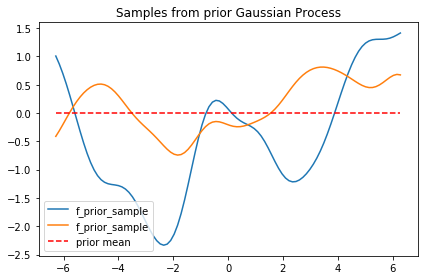

In [5]:
# Sample functions of prior distribution
fig2, ax2 = plt.subplots(figsize=(6, 4), tight_layout=True)
ax2.plot(X_test, f_prior_samples, label = 'f_prior_sample')
ax2.plot(X_test, prior_mean, 'r--', label = 'prior mean')
ax2.legend(loc = 'lower left')
plt.title('Samples from prior Gaussian Process')
plt.show()

## Predictive Distribution

For regression problems, we are not interested in generating random functions. Instead we only want to draw functions that comply with the training data $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$ and reject those that do not. This is achieved by conditioning the joint prior distribution of training outputs $\pmb{\mathrm{y}}$ and test outputs $\pmb{\mathrm{f}}_*$

$\begin{bmatrix} \pmb{\mathrm{y}} \\ \pmb{\mathrm{f}}_* \end{bmatrix} \sim \mathcal{N} \left( \pmb{0}, \begin{bmatrix} \pmb{K}(\pmb{X},\pmb{X}) + \sigma_n^2 \pmb{I} && \pmb{K}(\pmb{X},\pmb{X}_*) \\ \pmb{K}(\pmb{X}_*,\pmb{X}) && \pmb{K}(\pmb{X}_*,\pmb{X}_*) \end{bmatrix} \right)$

onto the training $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$ yielding the predictive distribution

$\pmb{\mathrm{f}}_* \rvert \pmb{X}, \pmb{y}, \pmb{X}_* \sim \mathcal{N} \left(\overline{\pmb{\mathrm{f}}}_*, \mathrm{cov}\left(\pmb{\mathrm{f}}_*\right)\right)$

with

$\overline{\pmb{\mathrm{f}}}_* = \mathbb{E}\begin{bmatrix}\pmb{\mathrm{f}}_* \rvert \pmb{X}, \pmb{y}, \pmb{X}_*\end{bmatrix} = \pmb{K}(\pmb{X}_*, \pmb{X})\left(\pmb{K}\left(\pmb{X}, \pmb{X}\right) + \sigma_n^2 \pmb{I}\right)^{-1}\pmb{y}$

being the mean of the predictive distribution and

$\mathrm{cov}\left(\overline{\pmb{\mathrm{f}}}_*\right) = \pmb{K}(\pmb{X}_*, \pmb{X}_*) - K(\pmb{X}_*, \pmb{X}) \left(\pmb{K}\left(\pmb{X}, \pmb{X}\right) + \sigma_n^2 \pmb{I}\right)^{-1} \pmb{K}(\pmb{X}, \pmb{X}_*)$

being the covariance matrix. The formulations contain the variance $\sigma_n^2$ that takes noise corrupting the training data into account. Note, the following implementation simply inverts $\pmb{K}\left(\pmb{X}, \pmb{X}\right) + \sigma_n^2\pmb{I}$ which is computationally quiet expensive. It would be better to use a Cholesky decomposition instead which is not done here to preserve the intuition and simplicity.

In [6]:
def predictive_distribution(X_test, X_train, y_train, sigma_n, sigma_f = 1, l = 1):
    """
    Calculates the mean and the covariance matrix of the predictive distribution
    
    """
    # Covariance matrix of training/ training
    K_traintrain = covariance_function(X_train, X_train, sigma_f, l) + sigma_n**2 * np.eye((covariance_function(X_train, X_train, sigma_f, l)).shape[0])

    # Covariance matrix of training / testing
    K_traintest = covariance_function(X_train, X_test, sigma_f, l)

    # Covariance matrix of testing / training
    K_testtrain = covariance_function(X_test, X_train, sigma_f, l)

    # Covariance matrix of testing / testing
    K_testtest = covariance_function(X_test, X_test, sigma_f, l)

    # Mean of predictive distribution
    f_mean = K_testtrain @ inv(K_traintrain) @ y_train

    # Covariance matrix of predictive distribution
    f_cov = K_testtest - K_testtrain @ inv(K_traintrain) @ K_traintest
    
    return f_mean, f_cov

## Predictions

In order to visualize the predictive distribution, we consider the two cases of noise-free observations and noisy observations in regression problems. 

#### Noise-free observations

In the noise-free case the training data $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$ are not corrupted by noise meaning that at the specific training input $x$ the corresponding training output $y(x)$ is a direct observation of the underlying function at $f(x)$. That means if the training data $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$ are for example governed by a cosine function, then the training output is

$y(x) = f(x) = \mathrm{cos}(x)$.

In [7]:
# Noise free training inputs
X_train = np.array([-4, -3, -0.9, 0.3, 2.4, 3.0]).reshape(-1,1)
f_train = np.cos(X_train)

# Noise-free training outputs
f = np.cos(X_test)

#### Noisy observations

Generally, the training data $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$ are corrupted by noise. Meaning that at a specific training input $x$ the corresponding training output $y(x)$ is not a direct observation of the underlying function at $f(x)$. We assume that the target function $f(x)$ is corruped by additive zero-mean Gaussian noise $\epsilon \sim \mathcal{N}\left(0, \sigma_n^2 \right)$, so that a noisy observation is yielded by $y(x) = f(x) + \epsilon$. Considering the example of the underlying cosine function $f(x) = \mathrm{cos}(x)$ the training output is generated by

$y(x) = f(x) + \epsilon = \mathrm{cos}(x) + \epsilon$.

In [8]:
# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.3
mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

#### Plot of noise-free target function and noise-free observations

This plot compares the two cases of noise-free and noisy observations. Note in the case of noisy observations, setting the noise variance $\sigma_n^2 = 0$ results in the case of noise-free observations again.

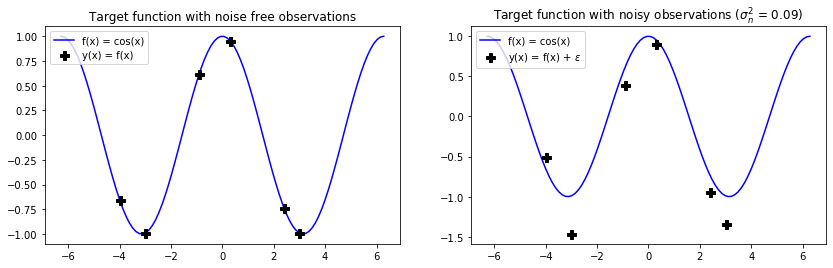

In [9]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(14, 4), tight_layout= False)

# Noise-free observations
axis1.plot(X_test, f, 'b', label = 'f(x) = cos(x)')
axis1.plot(X_train, f_train, 'kP', ms = 9, label = 'y(x) = f(x)')
axis1.legend(loc = 'upper left')
axis1.set_title('Target function with noise free observations')

# Noisy observations
axis2.plot(X_test, f, 'b', label = 'f(x) = cos(x)')
axis2.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
axis2.legend(loc = 'upper left')
axis2.set_title('Target function with noisy observations ($\sigma_n^2$ = {})'.format(sigma_n**2))

plt.show()

Using these training data $\mathcal{D} = \{\pmb{X},\pmb{\mathrm{y}}\}$, the test data $\pmb{X}_*$, and the variance of the noise $\sigma_n^2$ we can now draw function vectors from the predictive distribution $\pmb{\mathrm{f}}_* \rvert \pmb{X}, \pmb{y}, \pmb{X}_* \sim \mathcal{N}\left(\overline{\pmb{\mathrm{f}}}_*, \mathrm{cov}\left(\pmb{\mathrm{f}}_*\right)\right)$. Therefore, the predictive mean $\overline{\pmb{\mathrm{f}}}_*$ and the predictive covariance matrix $\mathrm{cov}\left(\overline{\pmb{\mathrm{f}}}_*\right)$ are calculated. For the noise-free case the noise variance is set to $\sigma_n^2 =0$.

In [10]:
# Predictive mean and predictive covariance matrix with noise-free observations
f_mean_noise_free, f_cov_noise_free = predictive_distribution(X_test, X_train, f_train, 0)

# Predictive mean and predictive covariance matrix with noisy observations
f_mean, f_cov = predictive_distribution(X_test, X_train, y_train, sigma_n)

To visualize the result, some sample functions $\pmb{\mathrm{f}}_*$ are drawn from the predictive distribution $\mathcal{N}(\overline{\pmb{\mathrm{f}}}_*, \mathrm{cov}(\pmb{\mathrm{f}}_*))$.

In [11]:
num_post_samples = 2

# Samples drawn from the predictive distribution with noise-free observations
f_post_samples_noise_free = np.random.multivariate_normal(f_mean_noise_free.reshape(num_test_samples,), f_cov_noise_free,1).reshape(X_test.shape)

if num_post_samples > 1:
    for post in range(1, num_post_samples):
        f_post_noise_free = np.random.multivariate_normal(f_mean_noise_free.reshape(num_test_samples,), f_cov_noise_free,1).reshape(X_test.shape)
        f_post_samples_noise_free = np.hstack((f_post_samples_noise_free, f_post_noise_free))
        
# Samples drawn from the predictive distribution with noisy observations
f_post_samples = np.random.multivariate_normal(f_mean.reshape(num_test_samples,), f_cov,1).reshape(X_test.shape)

if num_post_samples > 1:
    for post in range(1, num_post_samples):
        f_post = np.random.multivariate_normal(f_mean.reshape(num_test_samples,), f_cov,1).reshape(X_test.shape)
        f_post_samples = np.hstack((f_post_samples, f_post))

We also determine the standard deviation to quantify the uncertainty around the mean function $\overline{\pmb{\mathrm{f}}}_*$.

In [12]:
# Calculating variance and standard deviation for predictions with noisy observations

K_traintrain = covariance_function(X_train, X_train, sigma_f=1, l=1)
K_traintest = covariance_function(X_train, X_test, sigma_f=1, l=1)
K_testtest = covariance_function(X_test, X_test, sigma_f=1, l=1)

L_traintrain = np.linalg.cholesky(K_traintrain + sigma_n**2 * np.eye(K_traintrain.shape[0]))
L_traintest = np.linalg.solve(L_traintrain, K_traintest)

var = np.diag(K_testtest) - np.sum(L_traintest**2, axis=0)
stdv = np.sqrt(var)

# Calculating variance and standard deviation for predictions with noise-free observations
K_traintrain = covariance_function(X_train, X_train, sigma_f=1, l=1)
K_traintest = covariance_function(X_train, X_test, sigma_f=1, l=1)
K_testtest = covariance_function(X_test, X_test, sigma_f=1, l=1)

L_noise_free = np.linalg.cholesky(K_traintrain)# + sigma_n**2 * np.eye(K_traintrain.shape[0]))
Lk_noise_free = np.linalg.solve(L_noise_free, K_traintest)

# Variance and standard deviation
var_noise_free = np.diag(K_testtest) - np.sum(Lk_noise_free**2, axis=0)
stdv_noise_free = np.sqrt(var_noise_free)

Finally, this plot visualizes samples drawn from the predictive distribution $\mathcal{N}\left(\overline{\pmb{\mathrm{f}}}_*, \mathrm{cov} \left(\pmb{\mathrm{f}}_*\right)\right)$ alongside the predictive mean $\overline{\pmb{\mathrm{f}}}_*$ for the cases of noise-free and noisy observations.

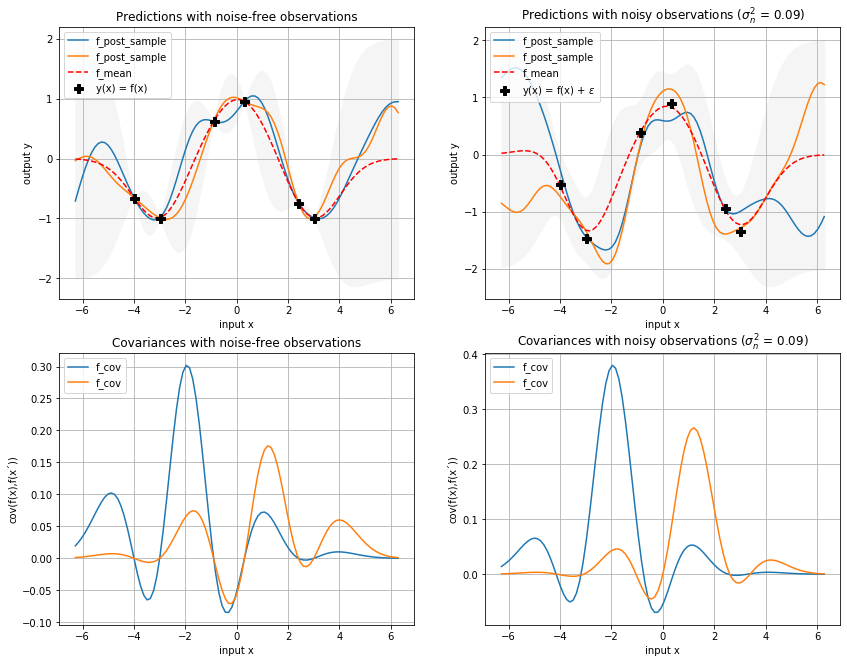

In [13]:
fig, (axs) = plt.subplots(2, 2, figsize=(14, 11), tight_layout= False)

# Plot predictions with noise-free observations
axs[0,0].plot(X_test, f_post_samples_noise_free, label = 'f_post_sample')
axs[0,0].plot(X_test, f_mean_noise_free, 'r--', label = 'f_mean')
axs[0,0].plot(X_train, f_train,'kP', ms = 9, label = 'y(x) = f(x)')
axs[0,0].fill_between(X_test.flat, f_mean_noise_free.reshape(X_test.size) - 2 * stdv_noise_free, f_mean_noise_free.reshape(X_test.size) + 2 * stdv_noise_free, color="whitesmoke")
axs[0,0].legend(loc = 'upper left')
axs[0,0].grid()
axs[0,0].set_xlabel('input x')
axs[0,0].set_ylabel('output y')
axs[0,0].set_title('Predictions with noise-free observations')

# Plot predictions with noisy observations
axs[0,1].plot(X_test, f_post_samples, label = 'f_post_sample')
axs[0,1].plot(X_test, f_mean, 'r--', label = 'f_mean')
axs[0,1].plot(X_train, y_train,'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
axs[0,1].fill_between(X_test.flat, f_mean.reshape(X_test.size) - 2 * stdv, f_mean.reshape(X_test.size) + 2 * stdv, color="whitesmoke")
axs[0,1].legend(loc = 'upper left')
axs[0,1].grid()
axs[0,1].set_xlabel('input x')
axs[0,1].set_ylabel('output y')
axs[0,1].set_title('Predictions with noisy observations ($\sigma_n^2$ = {})'.format(sigma_n**2))

# Plot of covariance with noise-free observations
axs[1,0].plot(X_test, f_cov_noise_free[34,:], label = 'f_cov')
axs[1,0].plot(X_test, f_cov_noise_free[56,:], label = 'f_cov')
axs[1,0].legend(loc = 'upper left')
axs[1,0].grid()
axs[1,0].set_xlabel('input x')
axs[1,0].set_ylabel('cov(f(x),f(x´))')
axs[1,0].set_title('Covariances with noise-free observations')

# Plot of covariance with noisy observations
axs[1,1].plot(X_test, f_cov[34,:], label = 'f_cov')
axs[1,1].plot(X_test, f_cov[56,:], label = 'f_cov')
axs[1,1].legend(loc = 'upper left')
axs[1,1].grid()
axs[1,1].set_xlabel('input x')
axs[1,1].set_ylabel('cov(f(x),f(x´))')
axs[1,1].set_title('Covariances with noisy observations ($\sigma_n^2$ = {})'.format(sigma_n**2))

plt.show()

In the two upper plots, the gray region visualizes the uncertainty for predictions. In the case of noise-free observations the uncertainty is zero at the training data whereas in the case of noisy observations the uncertainty at the training data is small. In both cases the uncertainty increases if only a few or no training points are present.

The two lower plots visualize the covariance between $f(\pmb{x})$ and $f\left(\pmb{x}'\right)$ for different values of $\pmb{x}'$. At training points the covariance is small in the case of noisy training points and even zero in the case of noise-free training points. 